In [1]:
%load_ext autoreload
%autoreload 2   # Change to %autoreload when development phase is over

# Table of Contents

<div id="toc"></div>

The following cell is a Javascript section of code for building the Jupyter notebook's table of content.

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# Define working environment

**Import libraries**

In [3]:
## Import libraries needed for setting parameters of operating system 
import os
import sys
## Import library for temporary files creation 
import tempfile 
## Import library for time management 
import time
## Import multiprocessing and functools libraries
import multiprocessing
from multiprocessing import Pool
from functools import partial
## Import pickle for transfert variable between notebooks
import pickle

In [4]:
## Import Pandas library
import pandas as pd
## Import Numpy library
import numpy as np

In [5]:
## Import Matplotlib 
import matplotlib as mpl 
## agg backend is used to create plot as a .png file
mpl.use('agg')
## Import Matplotlib.pyplot for creating graphs
import matplotlib.pyplot as plt 

In [6]:
%matplotlib inline

** Add folder with SCR provided belong to this notebook**

In [7]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

** Environment variables when working on Linux Mint **

In [8]:
import environ_variables as envi

In [9]:
# Set environmental variables
envi.setup_environmental_variables() 
# Display current environment variables of your computer
envi.print_environmental_variables()

MDMSESSION = mate 	
MANDATORY_PATH = /usr/share/gconf/mate.mandatory.path 	
MATE_DESKTOP_SESSION_ID = this-is-deprecated 	
LESSOPEN = | /usr/bin/lesspipe %s 	
MDM_LANG = fr_BE.UTF-8 	
LOGNAME = tais 	
USER = tais 	
HOME = /home/tais 	
XDG_VTNR = 8 	
PATH = /usr/local/bin:/home/tais/BIN:/home/tais/bin:/home/tais/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/home/tais/SRC/GRASS/grass_trunk/dist.x86_64-pc-linux-gnu/bin:/home/tais/SRC/GRASS/grass_trunk/dist.x86_64-pc-linux-gnu/script:/home/tais/SRC/GRASS/grass_trunk/dist.x86_64-pc-linux-gnu/lib 	
CLICOLOR = 1 	
DISPLAY = :0.0 	
SSH_AGENT_PID = 23350 	
LANG = fr_BE.UTF-8 	
TERM = xterm-color 	
SHELL = /bin/bash 	
GIS_LOCK = $$ 	
XAUTHORITY = /home/tais/.Xauthority 	
SESSION_MANAGER = local/tais-HP-Z620-Workstation:@/tmp/.ICE-unix/23279,unix/tais-HP-Z620-Workstation:/tmp/.ICE-unix/23279 	
SHLVL = 1 	
QT_LINUX_ACCESSIBILITY_ALWAYS_ON = 1 	
INSIDE_CAJA_PYTHON =  	
QT_ACCESSIBILITY = 1 	
LD

** GRASS GIS Python libraries **

In [10]:
## Import libraries needed to launch GRASS GIS in the jupyter notebook
import grass.script.setup as gsetup
## Import libraries needed to call GRASS using Python
import grass.script as gscript

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# User inputs

Here after:
- Enter the path to the directory you want to use as "[GRASSDATA](https://grass.osgeo.org/programming7/loc_struct.png)". 
- Enter the name of the location in which you want to work and its projection information in [EPSG code](http://spatialreference.org/ref/epsg/) format. Please note that the GRASSDATA folder and locations will be automatically created if not existing yet. If the location name already exists, the projection information will not be used.  
- Enter the name you want for the mapsets which will be used later for Unsupervised Segmentation Parameter Optimization (USPO), Segmentation and Classification steps.

In [11]:
## Define a empty dictionnary for saving user inputs
user={}

In [12]:
## Enter the path to GRASSDATA folder
user["gisdb"] = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/GRASSDATA"
## Enter the name of the location (existing or for a new one)
user["location"] = "Dakar_32628"
## Enter the EPSG code for this location 
user["locationepsg"] = "32628"
## Enter the name of the permanent mapset
user["permanent_mapset"] = "PERMANENT"
## Enter the name of a working mapset
user["dasym_mapset"] = "DASYMETRY"

In [13]:
# Set the name of the layers
Land_cover = 'landcover'  # VHR Land cover map
Land_use = 'landuse' # VHR Land use map
mr_builtup = 'MR_builtup' # MR built-up map
mr_built_pixelvalue = '1' # The value of built pixels in the MR built-up map
## Name of the column containing the population count
population_column = "POPULATION"
## Name of the column containing the density (response variable)
response_column = "popdens"

# Set a name for the empty grid layer
clumped_grid = 'clumped_grid'
# Set the resolution of the grid
tile_size = 100

** Functions defined by the user **

In [14]:
# Import function that check existance and create GRASS GIS database folder if needed
from grass_database import check_gisdb, check_location, check_mapset, working_mapset

In [15]:
## Import functions for processing time information
from processing_time import start_processing, print_processing_time

In [16]:
# Import function that generate a random name in the GRASS GIS environement
from random_layer_name import random_layer_name

In [17]:
# Import function that create color file for raster
from colorise_raster import create_color_rule

In [18]:
# Import function that clip multiple raster according to extention of a vector layer
from create_clumped_grid import create_clumped_grid

In [19]:
# Import function that create temp directories
from create_tempdirs import create_tempdirs

In [20]:
# Import function that rasterise a polygon layer and save the 'gridded' version as vector
from gridded_bound import gridded_admin_boundaries

In [21]:
# Import function that get list of class of categorical raster
from data_prep import data_prep

In [22]:
# Import csv functions (joint etc)
import csv_func
from csv_func import ordered_list_of_path, join_2csv, join_multiplecsv

**Check for existance of GRASSDATA folder, location and mapsets**

Here after, the python script will check if GRASSDATA folder, locations and mapsets already exist. If not, they will be automatically created.

In [23]:
# Check if the GRASS GIS database exists and create it if not
check_gisdb(user["gisdb"])

GRASSDATA folder already exist


In [24]:
# Check if the location exists and create it if not, with the CRS defined by the epsg code 
check_location(user["gisdb"],user["location"],user["locationepsg"])

Location Dakar_32628 already exist


In [25]:
# Check if the mapset exists and create it if not
check_mapset(user["gisdb"],user["location"],user["permanent_mapset"])

'PERMANENT' mapset already exists in location 'Dakar_32628'


In [26]:
# Check if the mapset exists and create it if not
check_mapset(user["gisdb"],user["location"],user["dasym_mapset"])

'DASYMETRY' mapset already exists in location 'Dakar_32628'


**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# Launch GRASS GIS working session on DASY_COVAR mapset

In [27]:
# Change the current working GRASS GIS session mapset
working_mapset(user["gisdb"],user["location"],user["dasym_mapset"])

You are now working in mapset 'DASYMETRY'


### Set several variables and parameter

In [56]:
# Declare list that will contain the name/paths of temporary layers/files
TMP_MAPS = []
TMP_CSV = []

# Declare strings that will contain the log of the processing
log_text = ""
log_text_extend = ""

In [57]:
# Set the number of job that could be runned in parallel
n_jobs = 15
# Check if the computer has enough cores
if(n_jobs >= multiprocessing.cpu_count()):
    gscript.fatal(_("Requested number of jobs is > or = to available ressources. \
                    Try to reduce to at maximum <%s> jobs")%(int(multiprocessing.cpu_count())-1))

### Create temporary directories for output

In [58]:
# Create temporary folder and get their paths
outputdirectory_admin, outputdirectory_grid = create_tempdirs(["admin_level", "grid_level"])

# Data preparation

## Create a clumped grid for dasymetry

This grid will be the reference grid for re-allocation of population count.

In [59]:
# Create clumped grid
create_clumped_grid(tile_size=tile_size, mask_raster=Land_cover, output=clumped_grid)

## Create layers with grid boundary for both levels

In [60]:
# Create layer with boundaries corresponding to the grid 
gridded_admin_units, gridded_vector = gridded_admin_boundaries("admin_level0", 'cluster', 
                                                               response_column, clumped_grid)

## Get list of values from categorical raster (land cover and land use)

In [61]:
# Data preparation : extract list of classes from the Land Cover
lc_classes_list = data_prep(Land_cover)[2]
message="Classes of raster '"+str(Land_cover)+"': "+",".join(lc_classes_list)
log_text+=message+'\n'

In [62]:
# Data preparation : extract list of classes from the land use
lu_classes_list = data_prep(Land_use)[2]
message="Classes of raster '"+str(Land_use)+"': "+",".join(lu_classes_list)
log_text+=message+'\n\n'

In [63]:
print log_text

Classes of raster 'landcover': 10,22,23,33,34,45,111,112,113
Classes of raster 'landuse': 1,2,3,4,5,6,7,8




## Compute proportion of each land cover and land use class

In [64]:
import categorical_prop
reload(categorical_prop)

<module 'categorical_prop' from '/media/tais/data/Dropbox/ULB/MAUPP/Traitements/population_modeling/SRC/categorical_prop.pyc'>

In [65]:
# Import function that compute proportion of each class of categorical raster in admin units (or raster segments)
from categorical_prop import proportion_class

### VHR Land cover proportions

In [66]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=Land_cover.split("@")[0])  #Set the region to match the extend of the raster
p=Pool(n_jobs) #Create a 'pool' of processes and launch them using 'map' function
func=partial(proportion_class,Land_cover.split("@")[0]) # Set fixed argument of the function
output=p.map(func,lc_classes_list) # Launch the processes for as many items in the list (if function with a return, the returned results are ordered thanks to 'map' function)
p.close()
p.join()
temp_rasterlist,temp_csvlist_1,temp_csvlist_2=zip(*output)
[TMP_MAPS.append(x) for x in temp_rasterlist]  # Append the name of binary rasters to the list of temporary maps
[TMP_CSV.append(x) for x in temp_csvlist_1]  # Append the paths to .csv files to the list of temporary .csv
[TMP_CSV.append(x) for x in temp_csvlist_2]  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of each class of categorical raster computed in: ")  

'Proportion of each class of categorical raster computed in: 2 minutes and 55.9 seconds'

### VHR Land use proportions

In [67]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=Land_use.split("@")[0])  #Set the region to match the extend of the raster
p=Pool(n_jobs) #Create a 'pool' of processes and launch them using 'map' function
func=partial(proportion_class,Land_use.split("@")[0]) # Set fixed argument of the function
output=p.map(func,lu_classes_list) # Launch the processes for as many items in the list (if function with a return, the returned results are ordered thanks to 'map' function)
p.close()
p.join()
temp_rasterlist,temp_csvlist_1,temp_csvlist_2=zip(*output)
[TMP_MAPS.append(x) for x in temp_rasterlist]  # Append the name of binary rasters to the list of temporary maps
[TMP_CSV.append(x) for x in temp_csvlist_1]  # Append the paths to .csv files to the list of temporary .csv
[TMP_CSV.append(x) for x in temp_csvlist_2]  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of each class of categorical raster computed in: ")  

'Proportion of each class of categorical raster computed in: 2 minutes and 52.3 seconds'

### MR Built-up proportion

In [68]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=mr_builtup.split("@")[0])  #Set the region to match the extend of the raster
temp_rasterlist,temp_csvlist_1,temp_csvlist_2 = proportion_class(mr_builtup.split("@")[0], mr_built_pixelvalue)
TMP_MAPS.append(temp_rasterlist)  # Append the name of binary rasters to the list of temporary maps
TMP_CSV.append(temp_csvlist_1)  # Append the paths to .csv files to the list of temporary .csv
TMP_CSV.append(temp_csvlist_2)  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of MR Built-up raster computed in: ")  

'Proportion of MR Built-up raster computed in: 1.8 seconds'

### Join all .csv files with statistics

In [69]:
## Join .csv files of statistics
for directory in [outputdirectory_grid, outputdirectory_admin]:
    allstatfile=os.path.join(directory,"all_stats.csv")
    pattern_A="LC_*_prop.csv"   #Add all csv with proportions of Land cover classes
    pattern_B="LU_*_prop.csv"  #Add all csv with proportions of Land use classes
    pattern_C="MR_*_prop.csv" 
    list_paths = ordered_list_of_path(directory,pattern_A,pattern_B,pattern_C)
    join_multiplecsv(list_paths,allstatfile,separator=",",join='inner', fillempty='NULL', overwrite=True)

### Visualisation of .csv files with statistics to be used

**Admin level**

In [70]:
## Use pandas for preview of .csv content
df_level0 = pd.read_csv(os.path.join(outputdirectory_admin,"all_stats.csv"))
print "There are %s rows in the dataframe"%len(df_level0)

There are 31 rows in the dataframe


In [71]:
## Display tail of the dataframe
df_level0.tail(8)

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion
23,74,5.44609,5.91458,2.68124,0.00000,0.00000,49.08486,21.50611,13.46562,1.90150,0.00000,0.00000,3.45283,26.16983,52.79673,16.88105,0.00000,0.69956,56.99945
24,77,1.36316,1.31126,0.30541,0.00000,0.00000,38.92091,33.22673,21.52354,3.34899,0.00000,0.00000,0.62612,0.24419,83.74707,7.59626,4.97949,2.80686,80.65275
25,83,8.87466,2.95357,4.83873,0.08761,0.00013,33.43845,25.37711,19.33013,5.09961,10.18482,0.00029,0.87334,12.74738,63.29016,9.10216,2.15430,1.64754,93.20068
26,88,12.13554,4.77274,11.22076,0.06122,0.00476,38.60738,11.72347,13.50141,7.97272,0.00000,0.00000,5.58492,42.58864,44.30365,6.49330,0.22309,0.80640,70.65887
27,92,6.05789,2.15854,4.21849,0.00000,0.00154,39.25266,28.18448,16.52687,3.59954,12.02512,0.00000,2.78709,2.62003,54.90128,7.05765,17.04959,3.55924,79.06778
28,93,1.43462,1.10928,2.34982,0.00000,0.00000,46.41957,29.16700,15.26735,4.25236,0.00000,2.12664,5.98514,0.00000,57.44911,6.31248,20.66817,7.45846,77.29529
29,98,7.46917,5.18816,16.77252,1.43169,0.00234,29.03204,36.52068,3.43304,0.15036,0.00000,1.91493,0.88379,0.21648,8.23175,19.05581,65.23036,4.46688,88.46832
30,99,3.72483,3.31699,1.42572,0.00000,0.00220,48.56620,17.14320,20.56331,5.25756,0.00000,0.00000,6.48800,3.57705,71.63279,14.71686,0.36076,3.22453,65.56557


**Grid level**

In [72]:
## Use pandas for preview of .csv content
df_grid = pd.read_csv(os.path.join(outputdirectory_grid,"all_stats.csv"))
print "There are %s rows in the dataframe"%len(df_grid)

There are 4195 rows in the dataframe


In [73]:
## Display tail of the dataframe
df_grid.tail(8)

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion
4187,4188,8.46750,6.90500,1.20000,0.0,0.0,22.71250,43.93000,13.52500,3.26000,0.0,0.0,0.0,0.00000,100.00000,0.000,0.0,0.00000,100.00000
4188,4189,6.02250,3.20000,0.16500,0.0,0.0,29.77000,39.67250,19.48500,1.68500,0.0,0.0,0.0,0.00000,99.82500,0.175,0.0,0.00000,100.00000
4189,4190,2.21000,9.04250,0.96250,0.0,0.0,35.73000,34.89750,17.15750,0.00000,0.0,0.0,0.0,9.57750,87.96500,2.455,0.0,0.00250,98.00000
4190,4191,21.83230,2.78172,0.00000,0.0,0.0,27.70186,28.18545,15.94055,3.55812,0.0,0.0,0.0,0.00000,99.47649,0.000,0.0,0.52351,98.07692
4191,4192,12.41513,2.59134,0.57010,0.0,0.0,33.85074,32.48769,16.51205,1.57295,0.0,0.0,0.0,0.00000,100.00000,0.000,0.0,0.00000,100.00000
4192,4193,15.18500,3.56750,4.58750,0.0,0.0,34.42250,32.62250,8.70500,0.91000,0.0,0.0,0.0,0.00000,74.82000,25.180,0.0,0.00000,100.00000
4193,4194,8.31750,5.70250,0.92000,0.0,0.0,37.93500,21.88750,25.23750,0.00000,0.0,0.0,0.0,32.55750,49.76250,17.680,0.0,0.00000,95.00000
4194,4195,15.30695,2.94180,0.04207,0.0,0.0,25.66183,40.25962,14.54972,1.23802,0.0,0.0,0.0,1.82397,98.17603,0.000,0.0,0.00000,90.47619


# Create simple weighting layer for MR built-up and VHR built-up

The weights are created simply by using the proportion computed for each grid

In [74]:
## Get the Grid statistics in a dataframe
all_stats_grid=os.path.join(outputdirectory_grid,"all_stats.csv") # for grid level
df_grid = pd.read_csv(all_stats_grid)
## Compute sum of VHR built-up proportion (3 classes of built-up)
df_grid['VHR_built_proportion'] = df_grid["LC_111_proportion"]+df_grid["LC_112_proportion"]+df_grid["LC_113_proportion"]

In [75]:
df_grid.tail()

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion,VHR_built_proportion
4190,4191,21.83230,2.78172,0.00000,0.0,0.0,27.70186,28.18545,15.94055,3.55812,0.0,0.0,0.0,0.00000,99.47649,0.00,0.0,0.52351,98.07692,47.68412
4191,4192,12.41513,2.59134,0.57010,0.0,0.0,33.85074,32.48769,16.51205,1.57295,0.0,0.0,0.0,0.00000,100.00000,0.00,0.0,0.00000,100.00000,50.57269
4192,4193,15.18500,3.56750,4.58750,0.0,0.0,34.42250,32.62250,8.70500,0.91000,0.0,0.0,0.0,0.00000,74.82000,25.18,0.0,0.00000,100.00000,42.23750
4193,4194,8.31750,5.70250,0.92000,0.0,0.0,37.93500,21.88750,25.23750,0.00000,0.0,0.0,0.0,32.55750,49.76250,17.68,0.0,0.00000,95.00000,47.12500
4194,4195,15.30695,2.94180,0.04207,0.0,0.0,25.66183,40.25962,14.54972,1.23802,0.0,0.0,0.0,1.82397,98.17603,0.00,0.0,0.00000,90.47619,56.04736


## Test A - MR built-up layer

In [76]:
# Name of test
test = 'A'
# Name of column with the proportion to use as weight 
weight_column = 'MR_1_proportion'

In [77]:
## Define a reclassification rule
cat_list=df_grid['cat'].tolist()
weight_list=df_grid[weight_column].tolist()
rule=""
for i, cat in enumerate(cat_list):
    rule+=str(cat)
    rule+="="
    rule+=str(int(round((weight_list[i]*10000),0)))  #reclass rule of r.reclass requier INTEGER values but random forest prediction could be very low values.
    rule+="\n"
rule+="*"
rule+="="
rule+="NULL"
## Create a temporary 'weight_reclass_rules.csv' file for r.reclass
outputcsv="%s_weight_reclass_rules.csv"%gscript.tempfile()
TMP_CSV.append(outputcsv)
f = open(outputcsv, 'w')
f.write(rule)
f.close()

In [78]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test

## Reclass segments raster layer
gscript.run_command('g.region', raster=clumped_grid)
gscript.run_command('r.reclass', quiet=True, overwrite=True, 
                    input=clumped_grid, output="weight_int", rules=outputcsv)
gscript.run_command('r.mapcalc', expression="%s=float(weight_int)/float(10000)"%output_weighting_layer, 
                    quiet=True, overwrite=True)

0

In [79]:
message = "-------------- TEST %s --------------\n"%test
message += "Simple weighting layer (not RF) based on '%s'"%weight_column
log_text+=message+'\n\n'

## Test B - VHR built-up layer

In [80]:
# Name of test
test = 'B'
# Name of column with the proportion to use as weight 
weight_column = 'VHR_built_proportion'

In [81]:
## Define a reclassification rule
cat_list=df_grid['cat'].tolist()
weight_list=df_grid[weight_column].tolist()
rule=""
for i, cat in enumerate(cat_list):
    rule+=str(cat)
    rule+="="
    rule+=str(int(round((weight_list[i]*10000),0)))  #reclass rule of r.reclass requier INTEGER values but random forest prediction could be very low values.
    rule+="\n"
rule+="*"
rule+="="
rule+="NULL"
## Create a temporary 'weight_reclass_rules.csv' file for r.reclass
outputcsv="%s_weight_reclass_rules.csv"%gscript.tempfile()
TMP_CSV.append(outputcsv)
f = open(outputcsv, 'w')
f.write(rule)
f.close()

In [82]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test

## Reclass segments raster layer
gscript.run_command('g.region', raster=clumped_grid)
gscript.run_command('r.reclass', quiet=True, overwrite=True, 
                    input=clumped_grid, output="weight_int", rules=outputcsv)
gscript.run_command('r.mapcalc', expression="%s=float(weight_int)/float(10000)"%output_weighting_layer, 
                    quiet=True, overwrite=True)

0

In [83]:
message = "-------------- TEST %s --------------\n"%test
message += "Simple weighting layer (not RF) based on '%s'"%weight_column
log_text+=message+'\n\n'

# Evaluate the importance of thematic detail in VHR layers

## Random Forest for creation of weights

### Define parameters

In [84]:
# Minimum feature importance for a feature to be kept in the final model
min_fimportance = 0.00
#min_fimportance = 0.05

In [85]:
# Parameter for the Grid Search for hyperparameter optimization
param_grid = {'oob_score': [True],'bootstrap': [True],
              'max_features': ['sqrt',0.05,0.1,0.2,0.3],
              'n_estimators': [250, 350, 500, 750]}
#try: literal_eval(param_grid)
#except: gscript.fatal(_("The syntax of the Python dictionary with model parameter is not as expected. Please refer to the manual"))

In [86]:
# Kfold parameter
kfold = 3
# Is kfold valid ?
maxfold=int(gscript.parse_command('v.db.univar', flags='g', map=gridded_vector, column='cat')['n'])   ## Corespond to leave-one-out cross-validation
if(kfold > maxfold):
    gscript.fatal(_("<kfold> parameter must be lower than %s (number of administratives area)"%maxfold))
if(kfold < 2):
    gscript.fatal(_("<kfold> parameter must be higher than 2"))

In [87]:
## Define the name of the legend classes for each input raster
# For VHR land cover
lc_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_VHR_landcover.txt"
# For VHR land use
lu_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_VHR_landuse.txt"
# For MR built-up
mr_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_MR_builtup.txt"

In [88]:
# Function that update the labels of feature importance plot according to the legend class name provided
from legend_csv import labels_from_csv

## Test C - 3 built-up classes comming from VHR

In [89]:
# Name of test
test = 'C'

In [90]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test
# Path to the folder where to save outputs
outputfolder = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s"%test
# Name of plot with feature importance (without file extension) 
plot_name = "RF_feature_importance"
# Generate paths for output of the test
path_plot = os.path.join(outputfolder,plot_name)

In [91]:
# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['111','112','113']  # land cover layer
lu_classes = []  # land use layer
mr_classes = []  # medium resolution built-up layer

In [92]:
# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['111','112','113']

In [98]:
import rf_model

In [99]:
reload(rf_model)

<module 'rf_model' from '/media/tais/data/Dropbox/ULB/MAUPP/Traitements/population_modeling/SRC/rf_model.py'>

In [100]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [96]:
message = "-------------- TEST %s --------------\n"%test
message += "Random Forest classifier for creating the weighting layer\n"
message += "VHR land cover classes used: %s \n"%(", ".join(lc_classes) if len(lc_classes)>0 else 'None')
message += "VHR land use classes used: %s \n"%(", ".join(lu_classes) if len(lu_classes)>0 else 'None')
message += "MR built-up classe used: %s \n"%(", ".join(mr_classes) if len(mr_classes)>0 else 'None')
message += "Layer '%s' used to force zero weights when proportion of class '%s' is null\n"%(layer_to_mask_weights, "', '".join(built_up_pixels))
print message
log_text+=message+'\n'

-------------- TEST C --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null



Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : 0.2
    n_estimators : 250
    oob_score : True
    bootstrap : True

Mean cross-validated score (OOB) and stddev of the best_estimator : -0.002 (+/-0.167)

Final Random Forest model run - internal Out-of-bag score (OOB) : 0.154


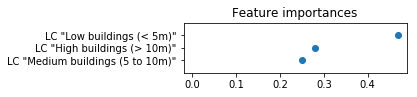

In [101]:
# Run the random forest model
RandomForest(output_weighting_layer,gridded_vector.split("@")[0],'cat', lc_classes, lu_classes, mr_classes)

## Test D

In [102]:
# Name of test
test = 'D'

In [103]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test
# Path to the folder where to save outputs
outputfolder = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s"%test
# Name of plot with feature importance (without file extension) 
plot_name = "RF_feature_importance"
# Generate paths for output of the test
path_plot = os.path.join(outputfolder,plot_name)

In [104]:
# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = []  # land use layer
mr_classes = []  # medium resolution built-up layer

In [105]:
# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['111','112','113']

In [106]:
import rf_model

In [107]:
reload(rf_model)

<module 'rf_model' from '/media/tais/data/Dropbox/ULB/MAUPP/Traitements/population_modeling/SRC/rf_model.pyc'>

In [108]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [109]:
message = "-------------- TEST %s --------------\n"%test
message += "Random Forest classifier for creating the weighting layer\n"
message += "VHR land cover classes used: %s \n"%(", ".join(lc_classes) if len(lc_classes)>0 else 'None')
message += "VHR land use classes used: %s \n"%(", ".join(lu_classes) if len(lu_classes)>0 else 'None')
message += "MR built-up classe used: %s \n"%(", ".join(mr_classes) if len(mr_classes)>0 else 'None')
message += "Layer '%s' used to force zero weights when proportion of class '%s' is null\n"%(layer_to_mask_weights, "', '".join(built_up_pixels))
print message
log_text+=message+'\n'

-------------- TEST D --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null



Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : sqrt
    n_estimators : 500
    oob_score : True
    bootstrap : True

Mean cross-validated score (OOB) and stddev of the best_estimator : 0.157 (+/-0.124)

Final Random Forest model run - internal Out-of-bag score (OOB) : 0.197


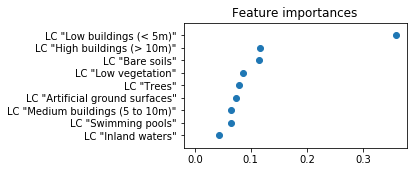

In [110]:
# Run the random forest model
RandomForest(output_weighting_layer,gridded_vector.split("@")[0],'cat', lc_classes, lu_classes, mr_classes)

## Test E

In [112]:
# Name of test
test = 'E'

In [113]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test
# Path to the folder where to save outputs
outputfolder = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s"%test
# Name of plot with feature importance (without file extension) 
plot_name = "RF_feature_importance"
# Generate paths for output of the test
path_plot = os.path.join(outputfolder,plot_name)

In [114]:
# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['111','112','113']  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

In [115]:
# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['111','112','113']

In [116]:
import rf_model

In [117]:
reload(rf_model)

<module 'rf_model' from '/media/tais/data/Dropbox/ULB/MAUPP/Traitements/population_modeling/SRC/rf_model.pyc'>

In [118]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [119]:
message = "-------------- TEST %s --------------\n"%test
message += "Random Forest classifier for creating the weighting layer\n"
message += "VHR land cover classes used: %s \n"%(", ".join(lc_classes) if len(lc_classes)>0 else 'None')
message += "VHR land use classes used: %s \n"%(", ".join(lu_classes) if len(lu_classes)>0 else 'None')
message += "MR built-up classe used: %s \n"%(", ".join(mr_classes) if len(mr_classes)>0 else 'None')
message += "Layer '%s' used to force zero weights when proportion of class '%s' is null\n"%(layer_to_mask_weights, "', '".join(built_up_pixels))
print message
log_text+=message+'\n'

-------------- TEST E --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null



Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : sqrt
    n_estimators : 250
    oob_score : True
    bootstrap : True

Mean cross-validated score (OOB) and stddev of the best_estimator : 0.232 (+/-0.335)

Final Random Forest model run - internal Out-of-bag score (OOB) : 0.501


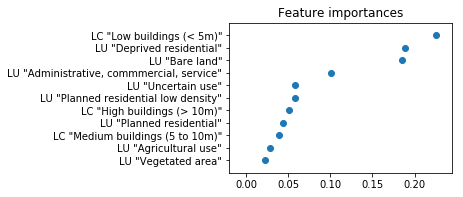

In [120]:
# Run the random forest model
RandomForest(output_weighting_layer,gridded_vector.split("@")[0],'cat', lc_classes, lu_classes, mr_classes)

## Test F

In [121]:
# Name of test
test = 'F'

In [122]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test
# Path to the folder where to save outputs
outputfolder = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s"%test
# Name of plot with feature importance (without file extension) 
plot_name = "RF_feature_importance"
# Generate paths for output of the test
path_plot = os.path.join(outputfolder,plot_name)

In [123]:
# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

In [124]:
# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['111','112','113']

In [125]:
import rf_model

In [126]:
reload(rf_model)

<module 'rf_model' from '/media/tais/data/Dropbox/ULB/MAUPP/Traitements/population_modeling/SRC/rf_model.pyc'>

In [127]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [128]:
message = "-------------- TEST %s --------------\n"%test
message += "Random Forest classifier for creating the weighting layer\n"
message += "VHR land cover classes used: %s \n"%(", ".join(lc_classes) if len(lc_classes)>0 else 'None')
message += "VHR land use classes used: %s \n"%(", ".join(lu_classes) if len(lu_classes)>0 else 'None')
message += "MR built-up classe used: %s \n"%(", ".join(mr_classes) if len(mr_classes)>0 else 'None')
message += "Layer '%s' used to force zero weights when proportion of class '%s' is null\n"%(layer_to_mask_weights, "', '".join(built_up_pixels))
print message
log_text+=message+'\n'

-------------- TEST F --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null



Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : 0.3
    n_estimators : 250
    oob_score : True
    bootstrap : True

Mean cross-validated score (OOB) and stddev of the best_estimator : 0.213 (+/-0.264)

Final Random Forest model run - internal Out-of-bag score (OOB) : 0.417


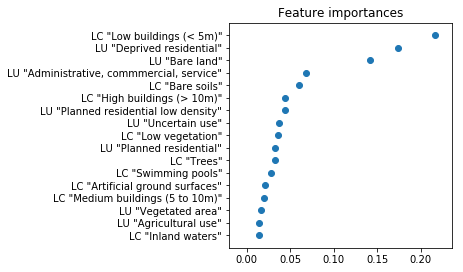

In [129]:
# Run the random forest model
RandomForest(output_weighting_layer,gridded_vector.split("@")[0],'cat', lc_classes, lu_classes, mr_classes)

## Test G

In [130]:
# Name of test
test = 'G'

In [131]:
# Name of the weighting layer to produce 
output_weighting_layer = "Test_%s_weight"%test
# Path to the folder where to save outputs
outputfolder = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/Random_Forest/Test_%s"%test
# Name of plot with feature importance (without file extension) 
plot_name = "RF_feature_importance"
# Generate paths for output of the test
path_plot = os.path.join(outputfolder,plot_name)

In [132]:
# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = ['1']  # medium resolution built-up layer

In [133]:
# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['111','112','113']

In [134]:
import rf_model

In [135]:
reload(rf_model)

<module 'rf_model' from '/media/tais/data/Dropbox/ULB/MAUPP/Traitements/population_modeling/SRC/rf_model.pyc'>

In [136]:
# Function that train a random forest model on admin units level and predict at grid level
from rf_model import RandomForest

In [137]:
message = "-------------- TEST %s --------------\n"%test
message += "Random Forest classifier for creating the weighting layer\n"
message += "VHR land cover classes used: %s \n"%(", ".join(lc_classes) if len(lc_classes)>0 else 'None')
message += "VHR land use classes used: %s \n"%(", ".join(lu_classes) if len(lu_classes)>0 else 'None')
message += "MR built-up classe used: %s \n"%(", ".join(mr_classes) if len(mr_classes)>0 else 'None')
message += "Layer '%s' used to force zero weights when proportion of class '%s' is null\n"%(layer_to_mask_weights, "', '".join(built_up_pixels))
print message
log_text+=message+'\n'

-------------- TEST G --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: 1 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null



Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : 0.3
    n_estimators : 350
    oob_score : True
    bootstrap : True

Mean cross-validated score (OOB) and stddev of the best_estimator : 0.258 (+/-0.255)

Final Random Forest model run - internal Out-of-bag score (OOB) : 0.413


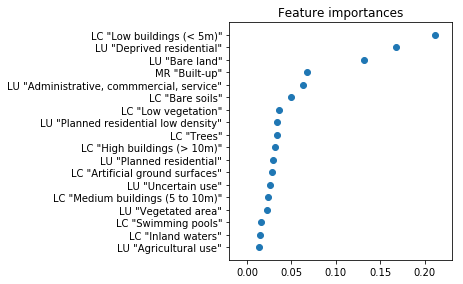

In [138]:
# Run the random forest model
RandomForest(output_weighting_layer,gridded_vector.split("@")[0],'cat', lc_classes, lu_classes, mr_classes)

In [139]:
print log_text

Classes of raster 'landcover': 10,22,23,33,34,45,111,112,113
Classes of raster 'landuse': 1,2,3,4,5,6,7,8

-------------- TEST A --------------
Simple weighting layer (not RF) based on 'MR_1_proportion'

-------------- TEST B --------------
Simple weighting layer (not RF) based on 'VHR_built_proportion'

-------------- TEST C --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null

-------------- TEST D --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '111', '112', '113' is null

-------------- TEST E --------------
Random Forest classifier for 

# Reallocate the population count using weighting layer

# Validation

In [ ]:
tests = ["Test_1","Test_2","Test_3","Test_4"]

In [ ]:

for test in tests:
    

In [85]:
for raster_layer in TMP_MAPS:
    gscript.run_command('g.remove', flags='f', type='raster', name=raster_layer)

# Export layers for archive or visualisation in another GIS

**VHR binary layers**

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/binary_rasters'
gscript.run_command('r.mask', overwrite=True, raster='maskcopy')  # Apply mask
# Export all binary raster
for binary_raster in TMP_MAPS:
    output_file = os.path.join(output_folder,'Dakar_binary_%s.tiff'%binary_raster)
    gscript.run_command('g.region', raster=binary_raster)
    gscript.run_command('r.out.gdal', overwrite=True, input=binary_raster, output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
gscript.run_command('r.mask', flags='r')  # Remove mask

**MR built-up mask**

**VHR built-up mask**

**Create VHR built-up binary (classes 111,112,113)**

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/binary_rasters'
gscript.run_command('r.mask', overwrite=True, raster='maskcopy')  # Apply mask
vhr_builtup = 'VHR_builtup'
gscript.use_temp_region()  # Define temp region
gscript.run_command('g.region', raster=Land_cover)
gscript.run_command('r.mapcalc', 
                    expression='%s=if(%s==111,111,if(%s==112,112,if(%s==113,113,0)))'%(vhr_builtup,Land_cover,Land_cover,Land_cover),
                    overwrite=True, quiet=True) # Mapcalc to create binary raster for the expected class 'cl'
# Export raster
output_file = os.path.join(output_folder,'Dakar_%s.tiff'%vhr_builtup)
gscript.run_command('r.out.gdal', overwrite=True, input=vhr_builtup, output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
gscript.run_command('r.mask', flags='r')  # Remove mask
gscript.del_temp_region() # Remove temp region

**Clumped Grid**

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar'
# Export clumped grid
output_file = os.path.join(output_folder,'Dakar_%s.tiff'%clumped_grid)
gscript.run_command('g.region', raster=clumped_grid)
gscript.run_command('r.out.gdal', overwrite=True, input=clumped_grid, output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')

**Gridded administrative units (level0)**

In [ ]:
# Set output folder
output_folder = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar'
# Export gridded admin units (level0)
output_file = os.path.join(output_folder,'Dakar_%s.shp'%gridded_vector)
gscript.run_command('v.out.ogr', overwrite=True, flags='m', type='area', 
                    input=gridded_vector, output=output_file, format='ESRI_Shapefile')